# Introduction and basic manipulation of FITS files

FITS = Flexible Image Transport System
* Designed to store multidimensional arrays and 2D tables containing rows and columns of data: e.g. images, data cubes, and tables
* A FITS file is comprised of segments called Header/Data Units (HDUs), where the first HDU is called the 'Primary HDU', or Primary Array'. 
* A typical primary array could contain a 1-D spectrum, a 2-D image, or a 3-D data cube. Any number of additional HDUs may follow the primary array. These additional HDUs are referred to as FITS 'extensions'. 
* The primary HDU has extension number '0'. The fits files used in our lab will only have the primary extension.

In a nutshell, FITS files have pairs of header+data units (HDUs):

Data unit
* contain an N-dimensional array of pixels (e.g. a 2D image array)

Header
* ascii (text) ﬁle consisting of multiple keywords (80-character records)
* general form KEYNAME = value / comment string


Adapted from https://fits.gsfc.nasa.gov/fits_primer.html

---

We start by loading the libraries we'll be using in this tutorial.

* The astropy 'fits' module provides the necessary functions for fits i/o and manipulation
* maplotlib for plots

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import csv

#ccdproc
import ccdproc as ccdp
from ccdproc import ImageFileCollection

Read a fits file and load it into a 'fits' object, including all HDUs 

In [7]:
read_path = './0_mainData/'  # this is OS dependent. Works for linux/mac
image_file = '4015b.fits'
hdu_list = fits.open(read_path+image_file)

The object's 'info' method shows that there is only one extension (the primary HDU) and that it stores a 1072*1024 array

In [5]:
hdu_list.info()

Filename: ./0_mainData/4015b.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   (1072, 1024)   int16 (rescales to uint16)   


Could also get this info by checking the file on disk without actually loading into a 'fits' object:

In [6]:
fits.info(read_path+image_file)

Filename: ./0_mainData/4015b.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   (1072, 1024)   int16 (rescales to uint16)   


We'll now read the data (data unit) from the object into a (numpy) array. This is the array that contains the image. Notice that the data is in the primary extension, this the '0' index.

In [7]:
image_data = hdu_list[0].data # zero é o "No." que está em cima; o ficheiro tivesse mais do que uma tabela
# de dados usariamos o índice correspondente à tabela que queremos ler;
# dados ficam guardados num array do numpy

#Could also be fetched directly from the file on disk with:
#image_data = fits.getdata(read_path+image_file, ext=0)

Check that it is indeed an array with the expected geometry

In [8]:
print(image_data.shape) # o numpy "inverte" a ordem dos elementos; o output é lido como (y, x)

(1024, 1072)


Lets take a look at the image. 

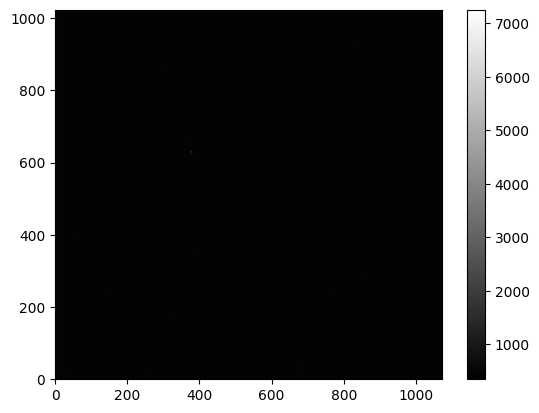

In [9]:
plt.figure()
plt.imshow(image_data, cmap='gray', origin = 'lower')
plt.colorbar()
#cmap defines the color map: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#origin=lower puts the y=0 at the bottom left instead of top left

Doesn't show much. As we will see, this is because some extreme values are stretching the colour scale.
Let's check the image histogram. For that we'll have to transform the array from 2D to 1D.

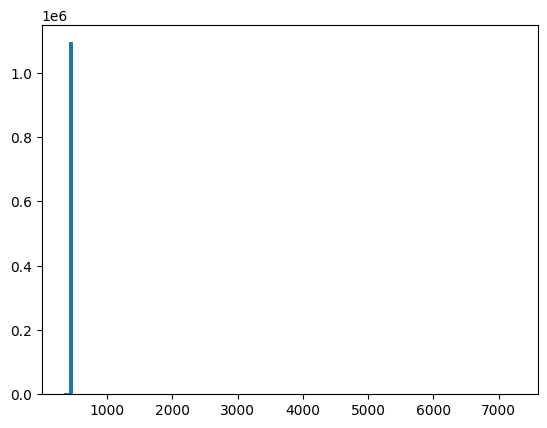

In [10]:
NBINS = 100
histogram = plt.hist(image_data.flat, NBINS)
# método flat transforma o array bi-dimensional (podia ser um conjunto de dados com mais dimensões)
# num array unidimansional;


Clearly, most data is around ~500, but there are extreme values up to ~35000. Let's zoom in around ~500: 

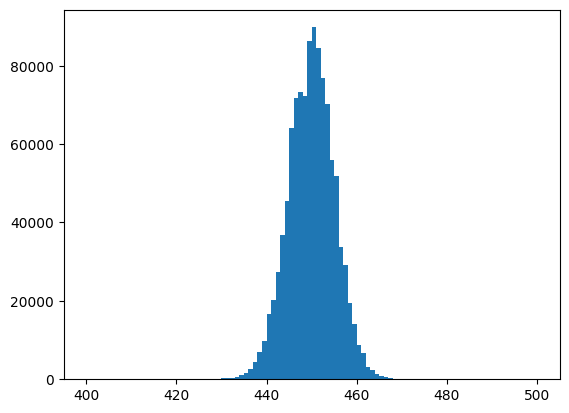

In [11]:
NBINS = 100
histogram = plt.hist(image_data.flat, NBINS, range = (400,500))


Indeed, most data is in this range. So now we'll display the image with the colour scale within these limits. And voilá!

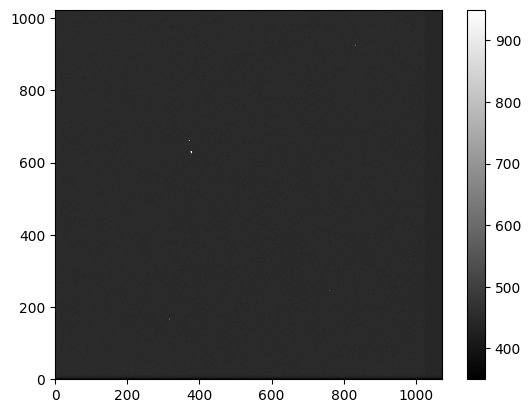

In [12]:
plt.imshow(image_data, cmap='gray', vmin=350, vmax=950, origin='lower')
plt.colorbar()

The dark strip on the right is called the overscan section. We'll come to this in another tutorial. For now, let's  check the counts over a horizontal cut of the image.

In [13]:
#Choose a line to cut, e.g. line 510
line=510
cut1=image_data[line,:] # : means all the colums at this row
print(cut1.shape)
cut2=image_data[line,900:1060] #here only the colums between 900 and 1060
print(cut2.shape)

(1072,)
(160,)


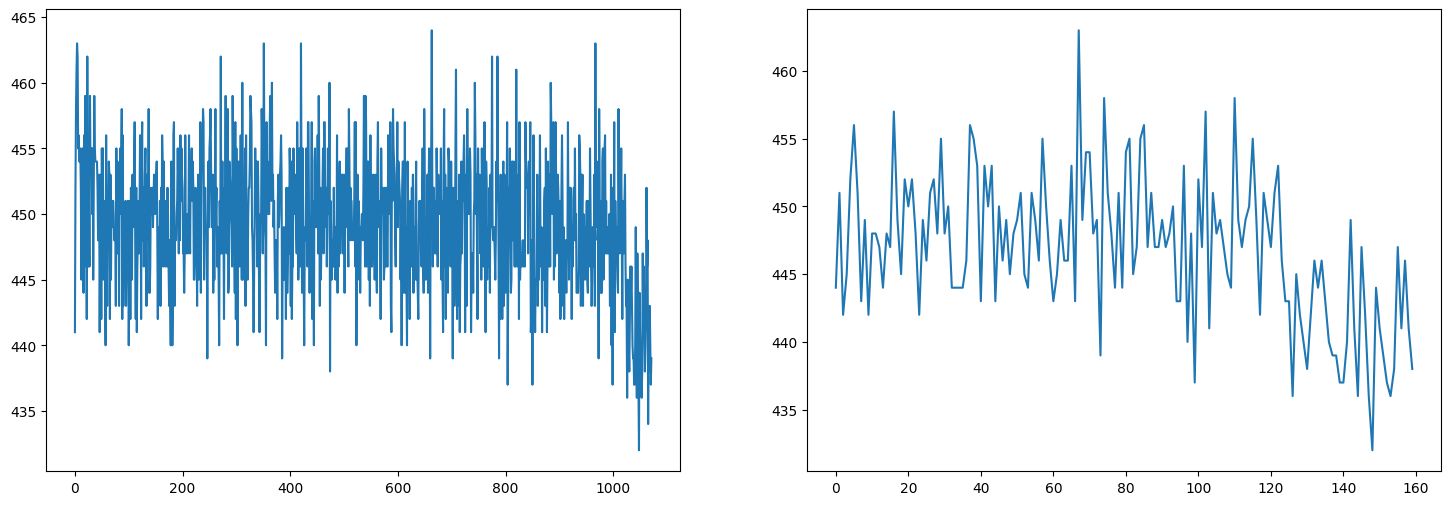

In [14]:
#Plot the cuts
nrow=1
ncol=2
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(nrow,ncol,1)
plt.plot(cut1)
ax = fig.add_subplot(nrow,ncol,2)
plt.plot(cut2)

Note that the  x axis labels in zoomed cut on the right don't correspond to the image pixel numbers. Why? Fix this in the cell below.

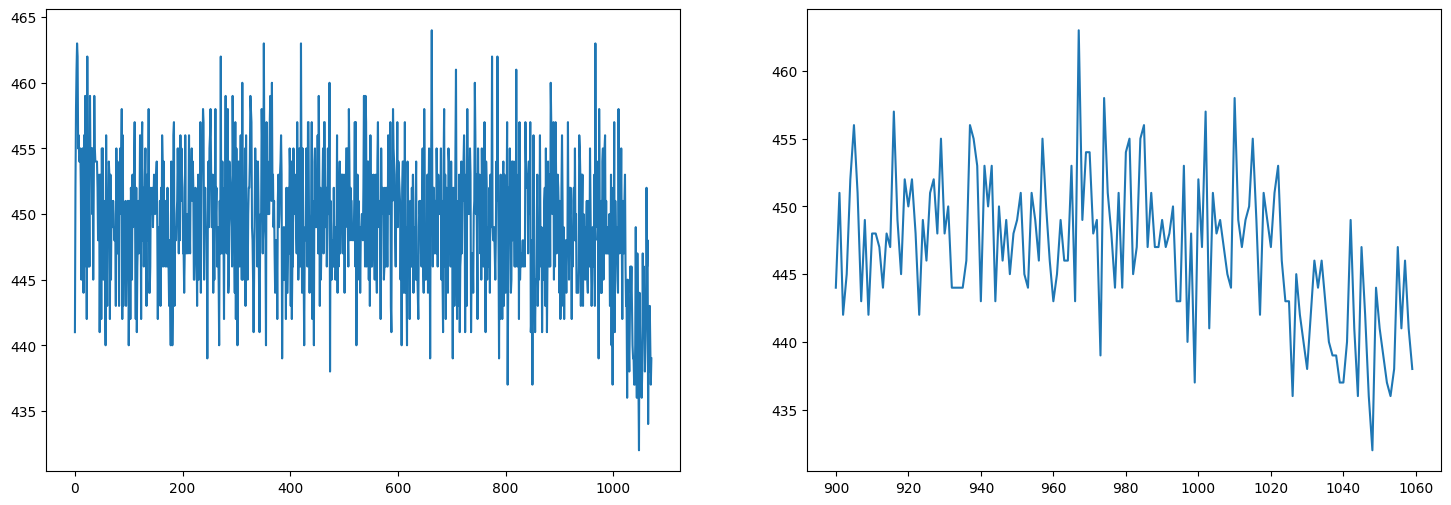

In [15]:
#Fix it here
cut2_x = []
for i in range(len(cut2)):
    cut2_x.append(i+900)

#Plot the cuts
nrow=1
ncol=2
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(nrow,ncol,1)
plt.plot(cut1)
ax = fig.add_subplot(nrow,ncol,2)
plt.plot(cut2_x,cut2)

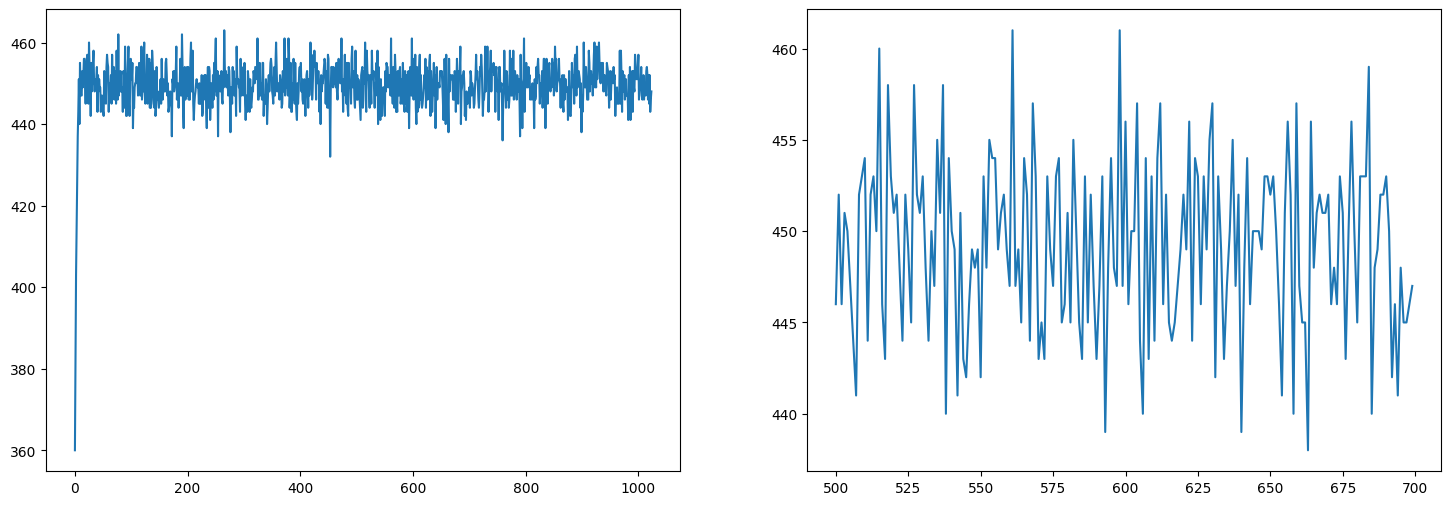

In [16]:
#As an exercise, plot a vertical cut (along a column):

#Choose a vertical line to cut, e.g. column 510
col=510
cut1=image_data[:,col] # : means all the colums at this row
cut2=image_data[500:700, col] #here only the colums between 900 and 1060

cut2_x = []
for i in range(len(cut2)):
    cut2_x.append(i+500)

#Plot the cuts
nrow=1
ncol=2
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(nrow,ncol,1)
plt.plot(cut1)
ax = fig.add_subplot(nrow,ncol,2)
plt.plot(cut2_x,cut2)

Now let's inspect and manipulate the image header. 
We start by reading the header from the fits object into a variable

In [17]:
image_header = hdu_list[0].header
image_header
#print(image_header)

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1072 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'Copyright (C) 1991-1998 GKR Computer Consulting' / FITS file originat
DATE    = '2001-06-05T23:49:42' / Date FITS file was generated                  
IRAF-TLM= '15:49:42 (05/06/2001)' / Time of last modification                   
EXPTIME =                    1                                                  
FILTER  = 'UNKNOWN '        

The strings on the left are the header keywords. They are followed by their value and optionally a comment separated by a '/'.  You may retrieve the values of keywords. e.g.:

In [18]:
image_header['OBSERVER']

'Moitinho'

Add keywords:

In [19]:
image_header['NEWKEY'] = 'done'
image_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1072 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'Copyright (C) 1991-1998 GKR Computer Consulting' / FITS file originat
DATE    = '2001-06-05T23:49:42' / Date FITS file was generated                  
IRAF-TLM= '15:49:42 (05/06/2001)' / Time of last modification                   
EXPTIME =                    1                                                  
FILTER  = 'UNKNOWN '        

Change the value of a keyword

In [20]:
image_header['NEWKEY'] = 'not done'
image_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1072 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'Copyright (C) 1991-1998 GKR Computer Consulting' / FITS file originat
DATE    = '2001-06-05T23:49:42' / Date FITS file was generated                  
IRAF-TLM= '15:49:42 (05/06/2001)' / Time of last modification                   
EXPTIME =                    1                                                  
FILTER  = 'UNKNOWN '        

Delete keywords and their entries

In [21]:
del image_header['NEWKEY']
image_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1072 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'Copyright (C) 1991-1998 GKR Computer Consulting' / FITS file originat
DATE    = '2001-06-05T23:49:42' / Date FITS file was generated                  
IRAF-TLM= '15:49:42 (05/06/2001)' / Time of last modification                   
EXPTIME =                    1                                                  
FILTER  = 'UNKNOWN '        

Change or add keywords and comments

In [22]:
image_header['MYVALUE'] = (9999,'Really important stuff')
image_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1072 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'Copyright (C) 1991-1998 GKR Computer Consulting' / FITS file originat
DATE    = '2001-06-05T23:49:42' / Date FITS file was generated                  
IRAF-TLM= '15:49:42 (05/06/2001)' / Time of last modification                   
EXPTIME =                    1                                                  
FILTER  = 'UNKNOWN '        

In [26]:
## FILE OBJECT IMAGETYP FILTER EXPTIME
files = ImageFileCollection(read_path)
files.summary['file', 'object', 'imagetyp', 'filter', 'exptime']

file,object,imagetyp,filter,exptime
str10,str8,str6,str7,int64
3241o.fits,NGC2420,OBJECT,I,5
3249o.fits,NGC2420,OBJECT,I,90
3262o.fits,NGC2420,OBJECT,V,10
3265o.fits,NGC2420,OBJECT,V,180
4015b.fits,UNKNOWN,BIAS,UNKNOWN,1
4016b.fits,UNKNOWN,BIAS,UNKNOWN,1
4017b.fits,UNKNOWN,BIAS,UNKNOWN,1
4075f.fits,Twilight,FLAT,V,3
4076f.fits,Twilight,FLAT,V,3


In [24]:
## FILE OBJECT IMAGETYP FILTER EXPTIME
Output = open('DataTableOutput.csv', "w")
for file in os.listdir(read_path):
    #print(file)
    hdu_list = fits.open(read_path+file)
    image_header = hdu_list[0].header
    Output.write(str(file)+"\t"+str(image_header['OBJECT'])+'\t'+str(image_header['IMAGETYP'])+'\t'+str(image_header['FILTER'])+'\t'+str(image_header['EXPTIME'])+"\n")
Output.close()

More on headers at
https://docs.astropy.org/en/stable/io/fits/usage/headers.html

Finally save your modifications in another fits file:

In [25]:
write_path = './'  # this is OS dependent. Works for linux/mac
newimage_file = '3241o_new.fits'
hdu_list.writeto(write_path+newimage_file,overwrite=True,output_verify='ignore')
#notice the 'overwrite' option. Use with caution